In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx

np.random.seed(0) # Fix seed for reproducibility
random.seed(0) # Fix seed for reproducibility

In [4]:
def generate_random_graph(n=10, weight_range=(1, 10)):
    # First thing is to create the map that we're trying to visit
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            weight = random.randint(*weight_range)
            matrix[i][j] = weight
            matrix[j][i] = weight
    return matrix

# 1. Initialisation

Créez une population initiale. Cette population est généralement générée aléatoirement. Chaque individu, ou chromosome, dans cette population représente une solution possible au problème (dans ce cas, une séquence possible de livraisons pour les véhicules).

In [5]:
def create_individual(nb_truck, nb_client, starting_point=0):
    """
    Create a random individual
    """
    individual = {}
    clients = list(range(1, nb_client))
    random.shuffle(clients)
    
    groups = np.array_split(clients, nb_truck)
    for i, group in enumerate(groups):
        individual[i] = [starting_point] + list(group) + [starting_point]
    return individual

def create_population(nb_truck, nb_client, starting_point=0, size=100):
    """
    Create a population of individuals
    """
    population = []
    for i in range(size):
        population.append(create_individual(nb_truck, nb_client, starting_point))
    return population

population = create_population(nb_truck=3, nb_client=10, size=10)
print(population)

[{0: [0, 7, 5, 4, 0], 1: [0, 1, 3, 9, 0], 2: [0, 2, 6, 8, 0]}, {0: [0, 8, 2, 6, 0], 1: [0, 1, 9, 5, 0], 2: [0, 7, 3, 4, 0]}, {0: [0, 2, 7, 4, 0], 1: [0, 6, 5, 3, 0], 2: [0, 1, 8, 9, 0]}, {0: [0, 4, 1, 8, 0], 1: [0, 3, 2, 5, 0], 2: [0, 7, 6, 9, 0]}, {0: [0, 4, 9, 1, 0], 1: [0, 8, 3, 2, 0], 2: [0, 5, 6, 7, 0]}, {0: [0, 7, 3, 8, 0], 1: [0, 2, 6, 9, 0], 2: [0, 4, 5, 1, 0]}, {0: [0, 9, 1, 4, 0], 1: [0, 3, 5, 6, 0], 2: [0, 8, 7, 2, 0]}, {0: [0, 1, 2, 6, 0], 1: [0, 8, 9, 3, 0], 2: [0, 5, 7, 4, 0]}, {0: [0, 9, 7, 8, 0], 1: [0, 3, 4, 1, 0], 2: [0, 5, 6, 2, 0]}, {0: [0, 4, 8, 7, 0], 1: [0, 3, 2, 6, 0], 2: [0, 9, 5, 1, 0]}]


# 2. Evaluation
Calculez la fonction de fitness pour chaque individu dans la population. La fonction de fitness détermine la qualité d'une solution. Dans le cas du VRP, cela pourrait être la distance totale parcourue par tous les véhicules.

In [6]:
def fitness(individual, adjency_matrix):
    """
    Compute the fitness of an individual
    """
    fitness = 0
    for truck in individual:
        for i in range(len(individual[truck])-1):
            fitness += adjency_matrix[individual[truck][i]][individual[truck][i+1]]
    return fitness

f = fitness(create_individual(3, 10), adjency_matrix)
print(f)



65.0


# 3. Selection
Sélectionnez des individus pour la reproduction. Il existe plusieurs stratégies de sélection, comme la sélection par roulette (plus la fitness d'un individu est élevée, plus il a de chances d'être sélectionné) ou la sélection par tournoi (choisissez aléatoirement quelques individus et sélectionnez le meilleur parmi eux).

In [9]:
def selection(population, adjency_matrix, k=10):
    """
    Select the best individuals in the population
    """
    population = sorted(population, key=lambda x: fitness(x, adjency_matrix))
    return population[:k]

# 4. Crossover
Créez une nouvelle génération de chromosomes en croisant les individus sélectionnés. Par exemple, en prenant la première moitié du chemin d'un parent et en complétant avec les villes restantes dans l'ordre qu'elles apparaissent dans le second parent.

In [178]:
import random

def crossover(individu1, individu2):
    # Choisir aléatoirement un cycle de chaque individu
    cycle1 = random.choice(list(individu1.keys()))
    cycle2 = random.choice(list(individu2.keys()))

    # Echanger ces cycles entre individus
    individu1[cycle1], individu2[cycle2] = individu2[cycle2], individu1[cycle1]

    # Assurer que les sommets ne sont visités qu'une seule fois
    for individu in [individu1, individu2]:
        sommets_visites = {}
        for cycle in individu:
            for sommet in individu[cycle][1:-1]:  # Exclure le départ et l'arrivée
                if sommet in sommets_visites:
                    # Si le sommet a déjà été visité, remplacer par un sommet non visité
                    non_visites = set(range(1, 10)) - set(sommets_visites.keys())
                    if non_visites:
                        new_sommet = random.choice(list(non_visites))
                        individu[cycle][individu[cycle].index(sommet)] = new_sommet
                        sommets_visites[new_sommet] = True
                else:
                    sommets_visites[sommet] = True

    return individu1, individu2

parent1 = create_individual(nb_truck=3, nb_client=10, starting_point=0)
parent2 = create_individual(nb_truck=3, nb_client=10, starting_point=0)
child = crossover(parent1, parent2)
print("Parent 1:", parent1)
print("Parent 2:", parent2)
print("Child:", child)

Parent 1: {0: [0, 6, 2, 8, 0], 1: [0, 3, 5, 4, 0], 2: [0, 7, 9, 1, 0]}
Parent 2: {0: [0, 9, 2, 4, 0], 1: [0, 7, 3, 1, 0], 2: [0, 5, 6, 8, 0]}
Child: {0: [0, 9, 2, 4, 0], 1: [0, 3, 5, 4, 0], 2: [0, 5, 6, 8, 0]}


# 4. Mutation
Apportez de petites modifications aléatoires à certains individus dans la nouvelle génération. Par exemple, en échangeant deux villes dans l'itinéraire.

In [174]:
def mutation(individual, adjency_matrix):
    """
    Mutate an individual
    """
    # We need to select a truck
    truck = random.choice(list(individual.keys()))
    # We need to select two clients
    client1, client2 = random.sample(range(1, len(individual[truck])-1), 2)
    # We need to swap the two clients
    individual[truck][client1], individual[truck][client2] = individual[truck][client2], individual[truck][client1]
    return individual

# 5. Remplacement
Remplacez l'ancienne population par la nouvelle génération d'individus.

In [25]:
def renew_population(population, adjency_matrix, k=10, mutation_rate=0.15):
    """
    Renew the population
    """
    # Select the best individuals
    population_reproduction = selection(population, adjency_matrix, k=k)
    # Create new individuals by crossover
    for i in range(len(population)):
        parent1 = random.choice(population_reproduction)
        parent2 = random.choice(population_reproduction)
        population[i] = crossover(parent1, parent2)
    # Mutate the individuals
    for i in range(len(population)):
        if random.random() < mutation_rate:
            population[i] = mutation(population[i], adjency_matrix)
    return population

population = create_population(nb_truck=3, nb_client=10, size=10)

# 6. Convergence
Vérifiez si l'algorithme a atteint un critère d'arrêt. Cela peut être un nombre maximum de générations, un temps d'exécution maximal, ou un seuil de fitness. Si le critère n'est pas atteint, revenez à l'étape 2.

In [28]:
def convergence(population, adjency_matrix):
    """
    Check if the population has converged
    """
    # We need to check if all the individuals have the same fitness
    fitnesses = [fitness(individual, adjency_matrix) for individual in population]
    return len(set(fitnesses)) == 1

# 7. Run

In [183]:
def genetic_algorithm(adjency_matrix, nb_truck, starting_point=0, population_size=100, k=10, mutation_rate=0.15):
    """
    Run the genetic algorithm
    """
    # Calculate the number of clients from the adjency matrix
    nb_client = len(adjency_matrix)

    # Create the initial population
    population = create_population(nb_truck, nb_client, starting_point, population_size)
    # While the population has not converged
    t = 0
    while not convergence(population, adjency_matrix):
        # Renew the population
        population = renew_population(population, adjency_matrix, k, mutation_rate)
        t += 1
        print("Iteration:", t, "Convergence:", convergence(population, adjency_matrix), "Best individual:", fitness(selection(population, adjency_matrix, k=1)[0], adjency_matrix))
    # Select the best individual
    best_individual = selection(population, adjency_matrix, k=1)[0]
    return best_individual

adjency_matrix = generate_random_graph(5)
best_individual = genetic_algorithm(adjency_matrix, nb_truck=1, starting_point=0, population_size=100, k=10, mutation_rate=1)
print(best_individual)

Iteration: 1 Convergence: False Best individual: 28.0
Iteration: 2 Convergence: False Best individual: 34.0
Iteration: 3 Convergence: True Best individual: 31.0
{0: [0, 1, 3, 2, 4, 0]}


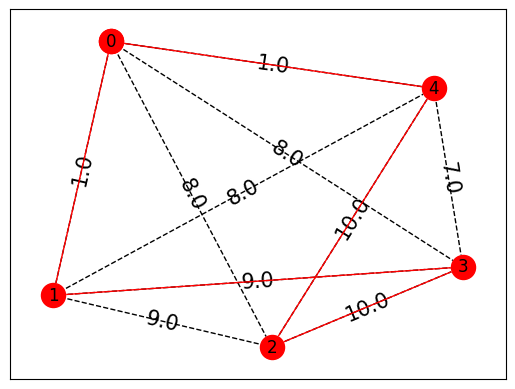

In [191]:
from mpl_interactions import ioff, panhandler, zoom_factory
import matplotlib.pyplot as plt
import networkx as nx


def plot_graph(adjency_matrix, trajets):
    # Liste des couleurs pour les différents trajets
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'grey']

    # Création du graphe
    G = nx.from_numpy_array(adjency_matrix)

    # Ajout des arêtes pour chaque trajet
    for camion, trajet in trajets.items():
        for i in range(len(trajet) - 1):
            G.add_edge(trajet[i], trajet[i+1], weight=adjency_matrix[trajet[i]][trajet[i+1]])

    # Dessin du graphe
    pos = nx.spring_layout(G)

    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)
    

    # Dessin des noeuds et des arêtes en noir
    nx.draw_networkx(G, pos, with_labels=True, node_color='white', edge_color='black', style='dashed')

    # Dessin des trajets par dessus en couleurs
    for camion, trajet in trajets.items():
        trajet_edges = [(trajet[i], trajet[i+1]) for i in range(len(trajet) - 1)]
        nx.draw_networkx_nodes(G, pos, nodelist=trajet, node_color=colors[camion])
        nx.draw_networkx_edges(G, pos, edgelist=trajet_edges, edge_color=colors[camion])

    plt.show()


plot_graph(adjency_matrix, best_individual)

In [14]:
# Check if an individual is valid
def is_valid(individual, adjency_matrix, starting_point=0):
    dict_client = {i:0 for i in range(len(adjency_matrix))}
    is_valid = True

    for truck, trajet in individual.items():
        # Check if the cycle starts and ends at the starting point
        if trajet[0] != starting_point or trajet[-1] != starting_point:
            is_valid = False
            break

        for vertice in trajet[1:-1]:
            dict_client[vertice] += 1

    # Check if all the clients are visited exactly once
    for client, nb_visits in dict_client.items():
        if nb_visits != 1:
            is_valid = False
            break

    return is_valid

is_valid(best_individual, adjency_matrix)
best_individual

{0: [0, 9, 8, 3, 0], 1: [0, 3, 9, 1, 0], 2: [0, 5, 1, 7, 0]}